In [1]:
import sys
import os
import yaml
import os
import glob

sys.path.append('..')

In [2]:
ckpt = '2409/cifar10-indi-l1/30'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'




ckpt = ckpt.strip('/').strip(' ')
ckpt

'2409/cifar10-indi-l1/30'

In [3]:
def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train","distributed"]
    return {k: opt[k]['value'] for k in keys}

In [4]:
opt = load_config(ckpt)

if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False



In [5]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

In [ ]:
unet = diffusion.netG.denoise_fn
# unet.time_mlp = None

In [ ]:
import torch
# start the training with mse loss with adam optimizer for unet. 
num_epochs = 20
batch_size = 16
# optimizer
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

# loss
criterion = torch.nn.L1Loss()

# dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


# training loop
# use tqdm for progress bar and log loss
import tqdm
import numpy as np
bar = tqdm.tqdm(range(num_epochs))
# rolling loss 
rolling_loss = []
rolling_count = 100
for epoch in bar:
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x = data['input']
        y = data['target']
        
        noise = torch.randn_like(y)
        # input = torch.cat([x, noise], dim=1)
        input = torch.cat([x,x], dim=1)
        input = input + torch.randn_like(input)*diffusion.netG.e

        t = torch.arange(len(input)).reshape(-1,).float().cuda()
        t = t / (1+t.max())

        input = input.cuda()
        y = y.cuda()
        
        y_pred = unet(input, t)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        rolling_loss.append(loss.item())
        msg = f'Epoch {epoch}, Iter {i}, Loss {np.mean(rolling_loss[-rolling_count:]):.4f}'
        bar.set_description(msg)
        if len(rolling_loss) > 10*rolling_count:
            rolling_loss = rolling_loss[-rolling_count:]
        
    if epoch % 10 == 0:
        print('Saving checkpoint')
        torch.save(unet.state_dict(), f'ckpt_{epoch}.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Iter 249, Loss 0.3484:   5%|▌         | 1/20 [00:14<04:30, 14.22s/it]

Saving checkpoint


Epoch 9, Iter 25, Loss 0.3508:  45%|████▌     | 9/20 [01:55<02:21, 12.88s/it] 


KeyboardInterrupt: 

In [ ]:
# now, predict on few images.
val_dloader = torch.utils.data.DataLoader(val_set, batch_size=10, shuffle=True, num_workers=4, pin_memory=True)
unet.eval()
for i, data in enumerate(val_dloader):
    x = data['input']
    y = data['target']
    noise = torch.randn_like(y)
    # input = torch.cat([x, noise], dim=1)
    input = torch.cat([x,x], dim=1)
    input = input + torch.randn_like(input)*diffusion.netG.e

    t = torch.arange(len(input)).reshape(-1,).float().cuda()
    t = t / (1+t.max())

    input = input.cuda()
    y = y.cuda()

    y_pred = unet(input, t)
    break

In [ ]:
x.shape

torch.Size([10, 3, 32, 32])

4
2
1
5


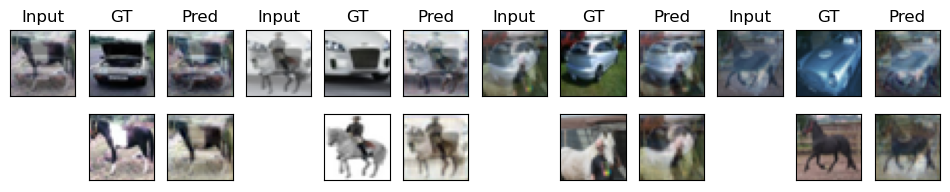

In [ ]:
import matplotlib.pyplot as plt
from disentangle.analysis.plot_utils import clean_ax
imgsz = 1
nimgs = 4
idx_list = np.random.choice(range(len(x)), size=nimgs, replace=False)
_,ax = plt.subplots(figsize=(3*nimgs*imgsz,2*imgsz),ncols=3*nimgs,nrows=2)
for img_idx in range(nimgs):
    idx = idx_list[img_idx]
    print(idx)
    inp = x[idx].cpu().numpy().transpose(1,2,0)
    tar = y[idx].cpu().numpy().transpose(1,2,0)
    pred = y_pred[idx].detach().cpu().numpy().transpose(1,2,0)

    pred = (pred + 1)/2 # [0,1]
    tar = (tar + 1)/2   # [0,1]
    inp = (inp + 1)/2   # [0,1]
    pred[pred<0] = 0
    pred[pred>1] = 1

    ax[0,img_idx*3 + 0].imshow(inp)
    ax[0,img_idx*3 + 1].imshow(tar[...,:3])
    ax[0,img_idx*3 + 2].imshow(pred[...,:3])
    ax[1,img_idx*3 + 1].imshow(tar[...,3:])
    ax[1,img_idx*3 + 2].imshow(pred[...,3:])
    ax[1, img_idx*3 + 0].axis('off')
    ax[0, img_idx*3 + 0].set_title('Input')
    ax[0, img_idx*3 + 1].set_title('GT')
    ax[0, img_idx*3 + 2].set_title('Pred')

clean_ax(ax)

In [ ]:
pred.max()

0.85385394